In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
import random
import cv2

In [2]:
zip_path = "custom_dataset.zip"
extract_path = "cdataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

dataset_dir = os.path.join(extract_path, "custom_dataset")

In [3]:
class_counts = {}
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len([
            f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

In [4]:
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"]).sort_values("Count")
print(df_counts)

          Class  Count
9       suprise      8
1       concern     12
3       curious     13
8       sadness     14
10   thoughtful     28
2   contentment     41
4          fear     42
6       natural     52
0         anger     61
7       neutral     73
5           joy     77


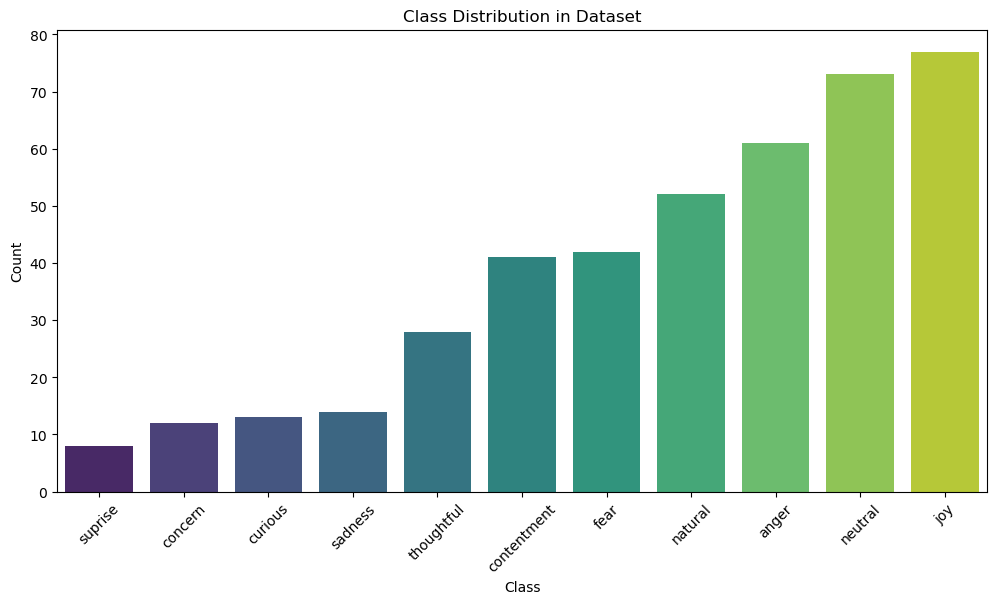

In [5]:
plt.figure(figsize=(12,6))
sns.barplot(x="Class", y="Count", data=df_counts, palette="viridis")
plt.xticks(rotation=45)
plt.title("Class Distribution in Dataset")
plt.show()

In [6]:
def show_samples(dataset_dir, classes, samples_per_class=3, img_size=(64,64)):
    plt.figure(figsize=(15, 15))
    i = 1
    for class_name in classes:
        class_path = os.path.join(dataset_dir, class_name)
        sample_files = random.sample(os.listdir(class_path), min(samples_per_class, len(os.listdir(class_path))))
        for file in sample_files:
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            plt.subplot(len(classes), samples_per_class, i)
            plt.imshow(img)
            plt.axis("off")
            plt.title(class_name)
            i += 1
    plt.show()

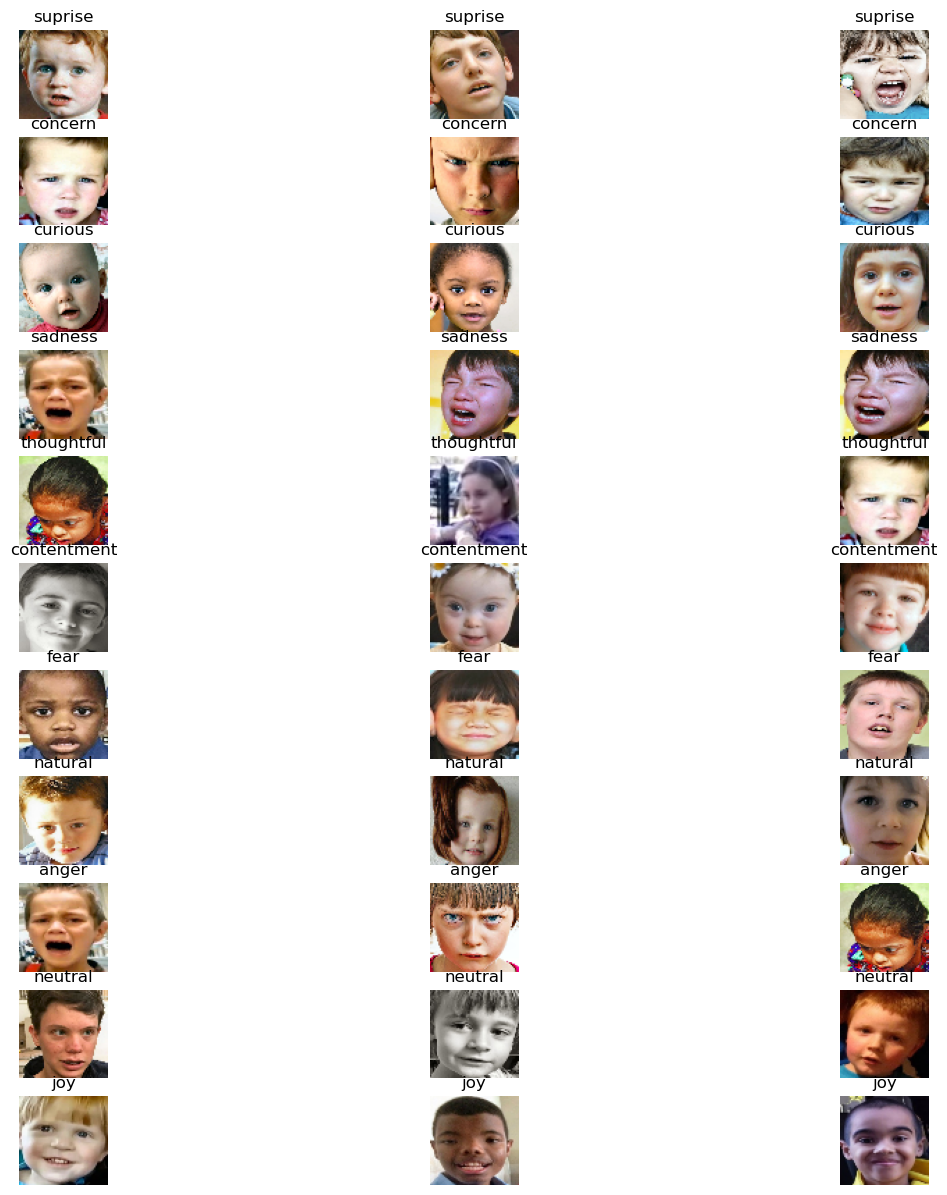

In [7]:
show_samples(dataset_dir, df_counts["Class"].tolist()[:11], samples_per_class=3)

In [8]:
min_count, max_count = df_counts["Count"].min(), df_counts["Count"].max()
print(f"Min images in a class: {min_count}, Max images in a class: {max_count}")

imbalance_ratio = max_count / min_count if min_count > 0 else "Infinity"
print(f"Imbalance Ratio (max/min): {imbalance_ratio}")

if imbalance_ratio > 1.5:
    print("Dataset is imbalanced. Consider using augmentation/upsampling for minority classes.")
else:
    print("Dataset looks fairly balanced.")

Min images in a class: 8, Max images in a class: 77
Imbalance Ratio (max/min): 9.625
Dataset is imbalanced. Consider using augmentation/upsampling for minority classes.


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import os

In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_images(class_dir, target_count):
    files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    n_existing = len(files)

    if n_existing >= target_count:
        return  # already has enough images
    
    for i in range(target_count - n_existing):
        img_path = os.path.join(class_dir, random.choice(files))
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # generate one augmented image
        it = datagen.flow(x, batch_size=1, save_to_dir=class_dir, save_prefix='aug', save_format='jpg')
        next(it)

target_count = 300
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        augment_images(class_path, target_count)

In [11]:
class_counts_after = {}
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        class_counts_after[class_name] = len([
            f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

df_counts_after = pd.DataFrame(list(class_counts_after.items()), columns=["Class", "Count"]).sort_values("Count")

print("Updated Class Counts after Upsampling:")
print(df_counts_after)

Updated Class Counts after Upsampling:
          Class  Count
10   thoughtful    293
6       natural    294
7       neutral    294
1       concern    295
3       curious    296
8       sadness    297
9       suprise    297
0         anger    298
2   contentment    298
5           joy    298
4          fear    299


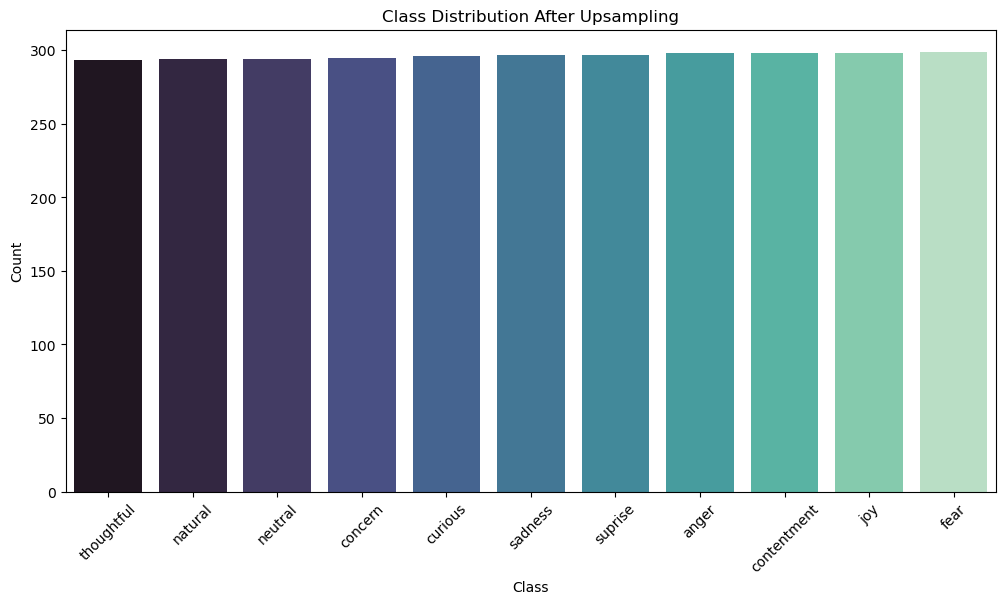

In [12]:
plt.figure(figsize=(12,6))
sns.barplot(x="Class", y="Count", data=df_counts_after, palette="mako")
plt.xticks(rotation=45)
plt.title("Class Distribution After Upsampling")
plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [14]:
img_size = (224, 224)   # MobileNetV2 input size
batch_size = 32
num_classes = len(df_counts_after)

In [15]:
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [16]:
train_gen = datagen.flow_from_directory(dataset_dir,target_size=img_size,batch_size=batch_size,class_mode='categorical',subset='training',shuffle=True)

Found 2613 images belonging to 11 classes.


In [17]:
val_gen = datagen.flow_from_directory(dataset_dir,target_size=img_size,batch_size=batch_size,class_mode='categorical',subset='validation',shuffle=False)

Found 646 images belonging to 11 classes.


In [18]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model initially
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,272,075 (8.67 MB)

 Trainable params: 14,091 (55.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
history = model.fit(train_gen,validation_data=val_gen,epochs=80)
model.save("mobilenetv2_emotions_1.keras")
model.save("mobilenetv2_emotions_1.h5")

Epoch 1/80


C:\Users\gayat\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 881ms/step - accuracy: 0.1771 - loss: 2.4484 - val_accuracy: 0.3638 - val_loss: 1.8737
Epoch 2/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 42s 497ms/step - accuracy: 0.3780 - loss: 1.8046 - val_accuracy: 0.4861 - val_loss: 1.5866
Epoch 3/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 534ms/step - accuracy: 0.5209 - loss: 1.5004 - val_accuracy: 0.5372 - val_loss: 1.4319
Epoch 4/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 42s 499ms/step - accuracy: 0.5744 - loss: 1.3162 - val_accuracy: 0.5573 - val_loss: 1.3403
Epoch 5/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 489ms/step - accuracy: 0.6049 - loss: 1.2311 - val_accuracy: 0.6037 - val_loss: 1.2676
Epoch 6/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 42s 502ms/step - accuracy: 0.6543 - loss: 1.0972 - val_accuracy: 0.6115 - val_loss: 1.2057
Epoch 7/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 516ms/step - accuracy: 0.6534 - loss: 1.0726 - val_accuracy: 0.6393 - val_loss: 1.1514
Epoch 8/80
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 543ms/step - accuracy: 0.6979 - loss: 0.9688 - val_accuracy: 0.654

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
val_gen.reset()
y_pred = model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step


In [23]:
class_labels = list(val_gen.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

       anger       0.40      0.49      0.44        59
     concern       0.84      0.86      0.85        59
 contentment       0.69      0.76      0.73        59
     curious       0.75      0.93      0.83        59
        fear       0.59      0.49      0.54        59
         joy       0.81      0.66      0.73        59
     natural       0.67      0.59      0.62        58
     neutral       0.50      0.55      0.52        58
     sadness       0.88      0.95      0.91        59
     suprise       0.95      0.97      0.96        59
  thoughtful       0.85      0.57      0.68        58

    accuracy                           0.71       646
   macro avg       0.72      0.71      0.71       646
weighted avg       0.72      0.71      0.71       646



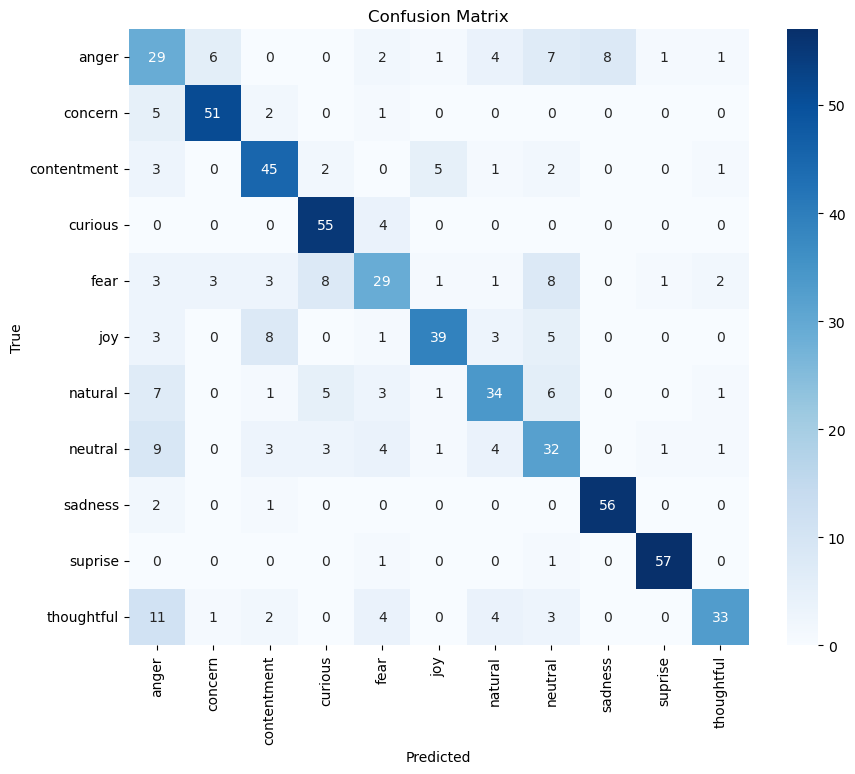

In [24]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

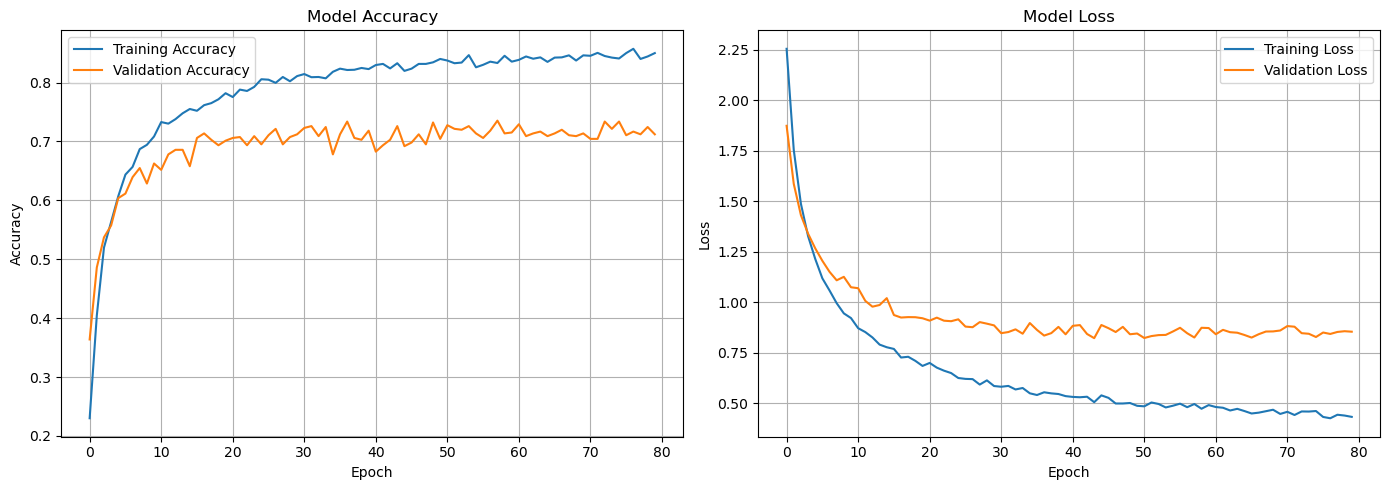

In [25]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
import pandas as pd

In [27]:
spotify_df = pd.read_csv("Music Info.csv")

In [28]:
print("Spotify dataset columns:\n", spotify_df.columns)

Spotify dataset columns:
 Index(['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id',
       'tags', 'genre', 'year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')


In [29]:
spotify_df = spotify_df.dropna(subset=["valence", "energy", "danceability"])

In [30]:
emotion_feature_map = {
    "anger":       {"valence": (0.2, 0.4), "energy": (0.7, 1.0)},
    "concern":     {"valence": (0.3, 0.5), "energy": (0.4, 0.6)},
    "contentment": {"valence": (0.6, 0.8), "energy": (0.4, 0.6)},
    "curious":     {"valence": (0.5, 0.7), "energy": (0.5, 0.7)},
    "fear":        {"valence": (0.1, 0.3), "energy": (0.5, 0.7)},
    "joy":         {"valence": (0.7, 1.0), "energy": (0.6, 0.9)},
    "natural":     {"valence": (0.4, 0.6), "energy": (0.4, 0.6)},
    "neutral":     {"valence": (0.45, 0.55), "energy": (0.45, 0.55)},
    "sadness":     {"valence": (0.0, 0.3), "energy": (0.0, 0.4)},
    "surprise":    {"valence": (0.6, 0.9), "energy": (0.6, 0.9)},
    "thoughtful":  {"valence": (0.3, 0.5), "energy": (0.3, 0.5)},
}

In [31]:
def recommend_song(emotion, n=5):
    if emotion not in emotion_feature_map:
        print(f"Emotion '{emotion}' not in mapping.")
        return None

    val_range = emotion_feature_map[emotion]["valence"]
    energy_range = emotion_feature_map[emotion]["energy"]

    # Filter songs based on emotion ranges
    candidates = spotify_df[
        (spotify_df["valence"] >= val_range[0]) & (spotify_df["valence"] <= val_range[1]) &
        (spotify_df["energy"]  >= energy_range[0]) & (spotify_df["energy"]  <= energy_range[1])
    ]

    if candidates.empty:
        print(f"No songs found for emotion '{emotion}'.")
        return None

    # Pick random top N songs
    result = candidates.sample(min(n, len(candidates)))

    return result[["track_id", "name", "artist", "spotify_preview_url", "genre", "year"]]

In [32]:
predicted_emotion = "joy"

print(f"\nRecommended songs for emotion: {predicted_emotion}")
recommendations = recommend_song(predicted_emotion, n=5)
print(recommendations)


Recommended songs for emotion: joy
                 track_id                 name          artist  \
49590  TRJAKHQ128E0792BB2               Tekere     Salif Keita   
17356  TRFOERI128F9331453             Bamboleo     Gipsy Kings   
5829   TRQELPH128F426FFEF              The Con  Tegan and Sara   
14245  TRKLEJT128E078EC6C  The Real Slim Shady          Eminem   
30343  TRNCSEZ128EF35F02F   Wędrówka z cieniem         Habakuk   

                                     spotify_preview_url   genre  year  
49590  https://p.scdn.co/mp3-preview/936e8def50bae815...   World  1995  
17356  https://p.scdn.co/mp3-preview/6032f8dab690507c...     NaN  2005  
5829   https://p.scdn.co/mp3-preview/2e17f453619ff436...     NaN  2007  
14245  https://p.scdn.co/mp3-preview/b18396be9b77ef54...     NaN  2000  
30343  https://p.scdn.co/mp3-preview/f2bbae6961c182e2...  Reggae  2007  


In [37]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import random
import webbrowser

In [38]:
image_path = None
predicted_emotion_gui = None
recommendations_gui = []

In [41]:
def predict_emotion_button():
    global predicted_emotion_gui, recommendations_gui
    if not image_path:
        messagebox.showwarning("Warning", "Please upload an image first!")
        return
    # Load and preprocess image for your model
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224,224))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0

    preds = model.predict(x)
    predicted_class_index = np.argmax(preds, axis=1)[0]
    predicted_emotion_gui = list(train_gen.class_indices.keys())[predicted_class_index]

    emotion_label.config(text=f"Predicted Emotion: {predicted_emotion_gui}")

    # Get recommended songs
    recommendations_gui = recommend_song(predicted_emotion_gui, n=5)
    if recommendations_gui is None:
        recommendations_gui = pd.DataFrame()

# Function to upload image
def upload_image():
    global image_path
    image_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
    if image_path:
        img = Image.open(image_path)
        img = img.resize((200, 200))
        img = ImageTk.PhotoImage(img)
        img_label.config(image=img)
        img_label.image = img

# Show recommended songs
def show_recommendations():
    if recommendations_gui is None or recommendations_gui.empty:
        messagebox.showwarning("Warning", "Please predict emotion first!")
        return
    rec_text = "\n".join([f"{i+1}. {row['name']} by {row['artist']}" for i, row in recommendations_gui.iterrows()])
    messagebox.showinfo("Recommended Songs", rec_text)

# Play a random song preview
def play_random_song():
    if recommendations_gui is None or recommendations_gui.empty:
        messagebox.showwarning("Warning", "Please predict emotion first!")
        return
    song = recommendations_gui.sample(1).iloc[0]
    url = song["spotify_preview_url"]
    if pd.isna(url):
        messagebox.showinfo("Info", f"No preview URL available for {song['name']}")
    else:
        webbrowser.open(url)

In [ ]:
root = tk.Tk()
root.title("Emotion Based Music Player")
root.geometry("600x500")

upload_btn = tk.Button(root, text="Upload Image", command=upload_image)
upload_btn.pack(pady=20)

img_label = tk.Label(root)
img_label.pack()

predict_btn = tk.Button(root, text="Predict Emotion", command=predict_emotion_button)
predict_btn.pack(pady=20)

emotion_label = tk.Label(root, text="", font=("Helvetica", 14))
emotion_label.pack(pady=10)

show_songs_btn = tk.Button(root, text="Show Recommended Songs", command=show_recommendations)
show_songs_btn.pack(pady=10)

play_random_btn = tk.Button(root, text="Play Random Song", command=play_random_song)
play_random_btn.pack(pady=10)

root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
